In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt

# Import PySwarms
import pyswarms as ps

## Load the dataset

In [2]:
import pandas as pd

dataset = pd.read_csv('data/creditcard.csv')
dataset.shape, dataset['Class'].sum()

2022-10-11 22:47:20,427 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


((284807, 31), 492)

In [3]:
from sklearn.model_selection import train_test_split

y = dataset['Class'].to_numpy()
X = dataset.drop('Class', axis=1).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
([i.shape for i in [X_train, X_test, y_train, y_test]], 
 [sum(i) for i in [y_train, y_test]])

([(170884, 30), (113923, 30), (170884,), (113923,)], [293, 199])

In [4]:
from imblearn.over_sampling import SMOTE

X, y = SMOTE().fit_resample(X_train, y_train)
([i.shape for i in [X, X_test, y, y_test]], 
 [sum(i) for i in [y, y_test]])

([(341182, 30), (113923, 30), (341182,), (113923,)], [170591, 199])

## Neural network architecture

In [5]:
n_inputs = X.shape[1]
n_hidden = 20
n_classes = 1
num_samples = len(y)

In [6]:
def logits_function(p, x):
    # Roll-back the weights and biases
    sep = n_inputs * n_hidden
    W1 = p[:sep].reshape((n_inputs,n_hidden))
    b1 = p[sep:sep+n_hidden].reshape((n_hidden,))
    W2 = p[sep+n_hidden:-n_classes].reshape((n_hidden,n_classes))
    b2 = p[-n_classes:].reshape((n_classes,))
    
    # Perform forward propagation
    z1 = x.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    logits = a1.dot(W2) + b2 # Pre-activation in Layer 2
    return 1 / (1 + np.exp(-logits)) # Sigmoid for Layer 2

In [7]:
from sklearn import metrics
# Forward propagation for one particle
def forward_prop(params):
    sample = (np.random.sample(size=1000)*X.shape[0]).astype('int')
    logits = logits_function(params, X[sample])
    return metrics.brier_score_loss(y[sample], logits)

In [8]:
# Forward propagation for entire swarm
def f(x):
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

## Performing PSO on the custom-function

In [9]:
%%time
# Initialize swarm
options = {'c1': 0.8, 'c2': 0.6, 'w': 0.9, 'k': 10, 'p': 2}

# Call instance of PSO
dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes 
optimizer = ps.single.LocalBestPSO(n_particles=200, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=1500)

2022-10-11 22:47:23,347 - pyswarms.single.local_best - INFO - Optimize for 1500 iters with {'c1': 0.8, 'c2': 0.6, 'w': 0.9, 'k': 10, 'p': 2}
pyswarms.single.local_best: 100%|██████████████████████████████████████████████████████████|1500/1500, best_cost=0.0311
2022-10-11 22:51:07,285 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 0.03109873023877615, best pos: [ 2.15643237e+00  2.35867616e-01  7.96342596e-01  1.12576924e+00
  2.51732640e+00  3.71501911e-01  6.75145178e-01  2.59987817e-01
  1.19181897e+00 -3.13717227e+00  3.66369272e-01  2.19409704e-01
  1.45115324e+00 -2.66912508e+00 -6.76409346e-01  9.10782613e-01
  8.49913400e-01  9.15160323e-01  8.43124765e-05  5.09262915e-01
 -1.35947745e-02  3.88792698e-01 -1.40289032e-01  1.73434157e+00
  2.23497173e+00  1.81801712e-01 -3.41159646e-02 -1.38228190e+00
  1.13032018e+00  4.06608325e-01 -7.26706569e-01  4.40150163e+00
  3.45230090e-01 -6.21510630e-01  2.03757142e+00 -8.05225609e-01
  2.10275690e-01  2.030729

CPU times: user 14min 30s, sys: 17.6 s, total: 14min 47s
Wall time: 3min 43s


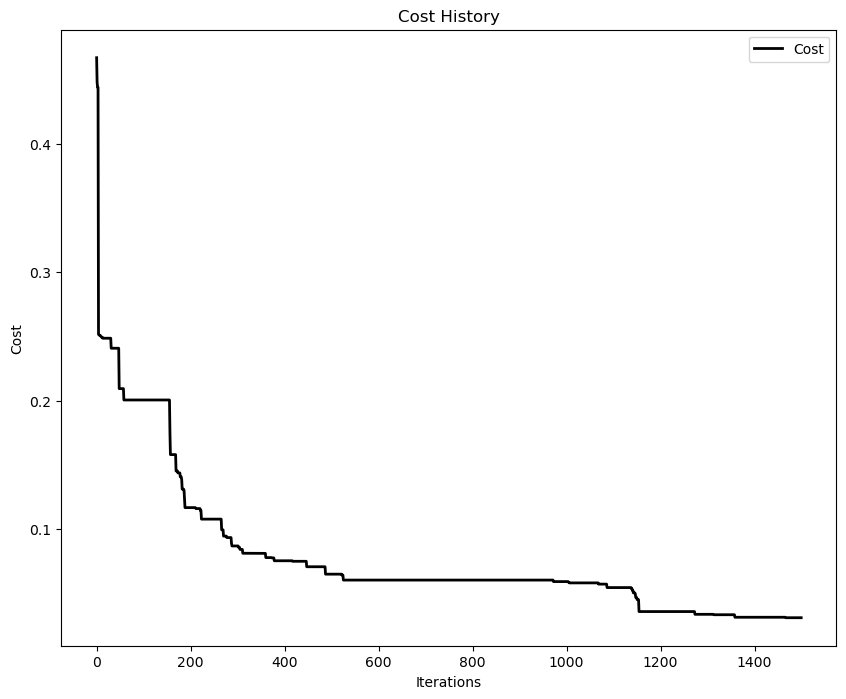

In [10]:
from pyswarms.utils import plotters

plotters.plot_cost_history(optimizer.cost_history)
plt.show()

## Checking the accuracy

In [11]:
def predict(pos, x):
    logits = logits_function(pos, x)
    return logits

AUROC 0.9323073944871203
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    113724
           1       0.04      0.90      0.08       199

    accuracy                           0.97    113923
   macro avg       0.52      0.93      0.53    113923
weighted avg       1.00      0.97      0.98    113923



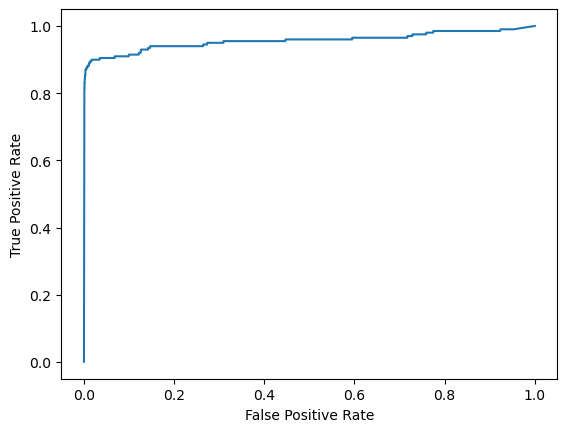

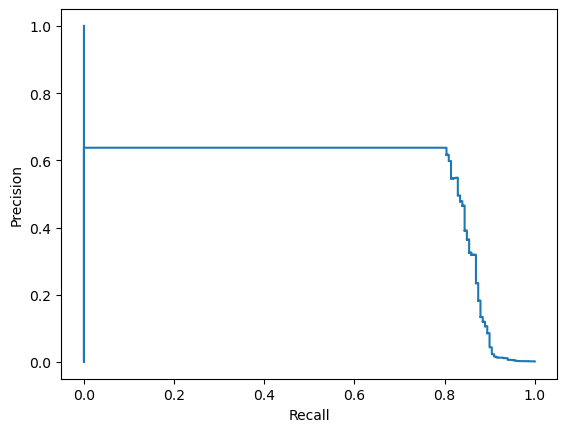

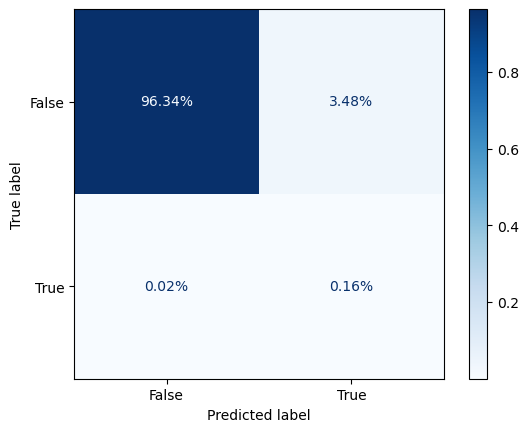

In [12]:
import matplotlib.pyplot as plt
from sklearn import metrics

# evaluate on test set
yhat = predict(pos, X_test)

#calculate precision and recall
precision, recall, thresh = metrics.precision_recall_curve(y_test, yhat)

fpr, tpr, threshold = metrics.roc_curve(y_test, yhat)

y_pred = yhat > threshold[tpr > 0.90][0]
print('AUROC', metrics.roc_auc_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
disp = metrics.PrecisionRecallDisplay(precision, recall).plot()
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_test.astype('bool'), y_pred.astype('bool'), cmap='Blues',
    normalize='all', values_format='.2%')